In [1]:
from attention import AttentionLayer # from here https://github.com/thushv89/attention_keras/blob/master/layers/attention.py

In [2]:
import os
import re
import sys
import numpy as np
import pandas as pd
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

from keras import backend as K, layers
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional

Using TensorFlow backend.


In [3]:
os.getcwd()

'/home/nemo/Documents/school/Final Project'

In [4]:
data = pd.read_csv(os.getcwd() + '/amazon-fine-food-reviews/Reviews.csv')

In [5]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."


In [6]:
print("shape: ", data.shape)
data.info()

shape:  (568454, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [8]:
cleaning = data.drop_duplicates(subset=['Text'])
cleaning = data.dropna(axis=0)
print("shape: ", cleaning.shape)

shape:  (568411, 10)


In [9]:
## contrations to full formed phrase
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [10]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text  ## html
    newString = re.sub(r'\([^)]*\)', '', newString)   ## parenthesis
    newString = re.sub('"','', newString)   ## quotes
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) ## non-alphabet letters
    newString = re.sub('[m]{2,}', 'mm', newString) 
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                ##removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [11]:
def clean_text(data, feature, index):
    cleaned = []
    count = data.shape[0]
    for i, text in enumerate(data[feature]):
        cleaned.append(text_cleaner(text, index))
        print(str(i/count*100) +"%", sep='', end='\r')
    return cleaned

In [12]:
cleaned_text = clean_text(cleaning, 'Text', 0)

In [13]:
cleaned_summary = clean_text(cleaning, 'Summary', 1)

In [14]:
## texts
cleaned_text[:3]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch']

In [15]:
## summaries
cleaned_summary[:3]

['good quality dog food', 'not as advertised', 'delight says it all']

In [16]:
cleaning['cleaned_text']=cleaned_text
cleaning['cleaned_summary']=cleaned_summary

In [17]:
cleaning.replace('', np.nan, inplace=True)
cleaning.dropna(axis=0,inplace=True)

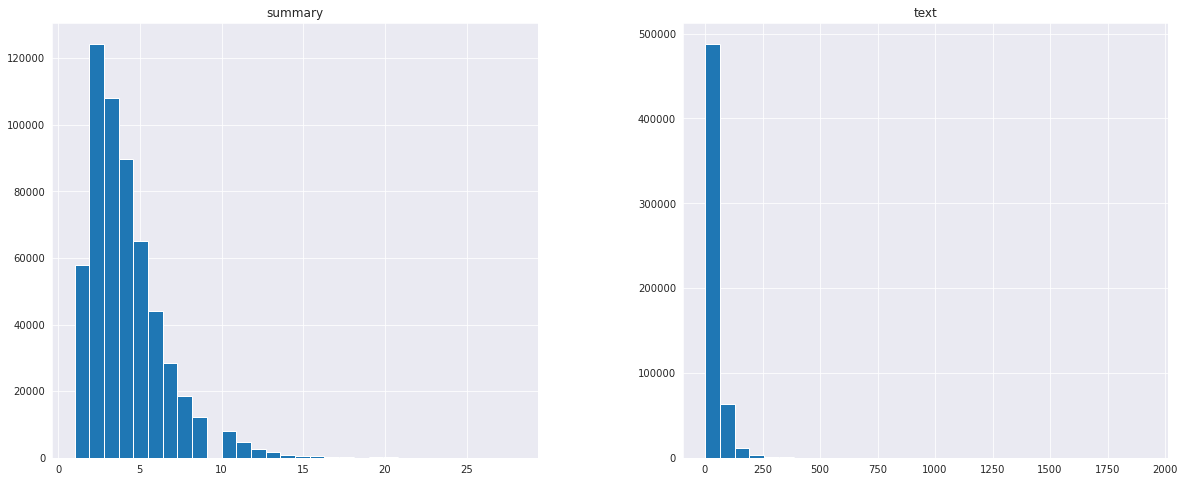

In [18]:
text_word_count = []
summary_word_count = []

for text in cleaning['cleaned_text']:
    text_word_count.append(len(text.split()))
    
for text in cleaning['cleaned_summary']:
    summary_word_count.append(len(text.split()))


length_df = pd.DataFrame({'text': text_word_count, 'summary': summary_word_count})
length_df.hist(bins=30, figsize=(20,8))
plt.show()

### Determine size of summaries and text

In [19]:
cnt=0
for i in cleaning['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(cleaning['cleaned_summary']))

0.9796298546146681


In [20]:
cnt=0
for i in cleaning['cleaned_text']:
    if(len(i.split())<=140):
        cnt=cnt+1
print(cnt/len(cleaning['cleaned_text']))

0.9778849489117669


In [21]:
max_text_len=140 ##original tweet character limit
max_summary_len=10

In [22]:
cleaned_text =np.array(cleaning['cleaned_text'])
cleaned_summary=np.array(cleaning['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [23]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [24]:
df.head(2)

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok


### Splitting into train and test

In [25]:
x_train, x_val, y_train, y_val = train_test_split(np.array(df['text']), np.array(df['summary']), \
                                                  test_size=0.2, random_state=0, shuffle=True) 

### tokenize text

In [26]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [27]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 43.84752720927183
Total Coverage of rare words: 0.29215902833566204


In [28]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_train    =   pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

55670

### tokenize summary

In [29]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [30]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 42.915752988611445
Total Coverage of rare words: 0.48205445618306153


In [31]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
y_voc

16141

In [32]:
y_tokenizer.word_counts['sostok'],len(y_train) 

(436099, 436099)

In [33]:
## delete entries with just start and end tokens
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
x_train=np.delete(x_train,ind, axis=0)

In [34]:
## delete entries with just start and end tokens
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

### plotting

In [35]:
def plotloss(history_dict):
    acc = history_dict['acc']
    loss_values = history_dict['loss']
#     val_loss_values = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 10))
    plt.plot(epochs, loss_values, 'r', label='Training loss')
#     plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plotacc(history):
    acc = history.history['acc']
#     val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 10))
    plt.plot(epochs, acc, 'r', label='Training acc')
#     plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### my computer doesn't like tensorflow after I play a game or use the gpu 

In [36]:
import gc
from numba import cuda

In [37]:
# K.clear_session()
# gc.collect()

# cuda.select_device(0)
# cuda.close()

In [38]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Gpus:", str(gpus))
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPUs


# Model  1

In [114]:
K.clear_session()
    
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 140, 100)     5567000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 140, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [115]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy')

In [116]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=2)

In [42]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=10,
                  callbacks=[es],
                  batch_size=256,
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Train on 434714 samples, validate on 108501 samples
Epoch 1/10
434714/434714 [==============================] - 1301s 3ms/sample - loss: 2.5814 - val_loss: 2.3142
Epoch 2/10
434714/434714 [==============================] - 1288s 3ms/sample - loss: 2.2353 - val_loss: 2.1391
Epoch 3/10
434714/434714 [==============================] - 1286s 3ms/sample - loss: 2.1162 - val_loss: 2.0404
Epoch 4/10
434714/434714 [==============================] - 1286s 3ms/sample - loss: 2.0462 - val_loss: 1.9834
Epoch 5/10
434714/434714 [==============================] - 1284s 3ms/sample - loss: 1.9965 - val_loss: 1.9540
Epoch 6/10
434714/434714 [==============================] - 1285s 3ms/sample - loss: 1.9581 - val_loss: 1.9158
Epoch 7/10
434714/434714 [==============================] - 1283s 3ms/sample - loss: 1.9307 - val_loss: 1.8808
Epoch 8/10
434714/434714 [==============================] - 1284s 3ms/sample - loss: 1.9062 - val_loss: 1.8644
Epoch 9/10
434714/434714 [==============================] - 

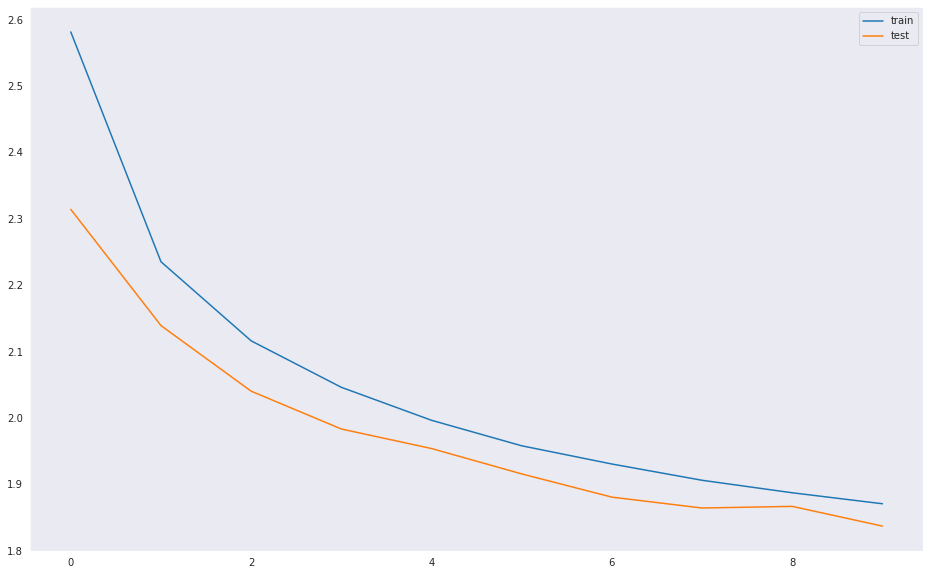

In [47]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [48]:
# model.save('fp_m1.h5')  ## 10 epoch test

## Model 1 - 15 Epochs

In [108]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=15,
                  callbacks=[es],
                  batch_size=256,
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Train on 434714 samples, validate on 108501 samples
Epoch 1/15
434714/434714 [==============================] - 1353s 3ms/sample - loss: 2.5565 - val_loss: 2.2604
Epoch 2/15
434714/434714 [==============================] - 1329s 3ms/sample - loss: 2.2006 - val_loss: 2.1058
Epoch 3/15
434714/434714 [==============================] - 1332s 3ms/sample - loss: 2.0887 - val_loss: 2.0192
Epoch 4/15
434714/434714 [==============================] - 1332s 3ms/sample - loss: 2.0244 - val_loss: 1.9595
Epoch 5/15
434714/434714 [==============================] - 1331s 3ms/sample - loss: 1.9788 - val_loss: 1.9276
Epoch 6/15
434714/434714 [==============================] - 1331s 3ms/sample - loss: 1.9466 - val_loss: 1.8989
Epoch 7/15
434714/434714 [==============================] - 1321s 3ms/sample - loss: 1.9217 - val_loss: 1.8776
Epoch 8/15
434714/434714 [==============================] - 1318s 3ms/sample - loss: 1.8987 - val_loss: 1.8555
Epoch 9/15
434714/434714 [==============================] - 

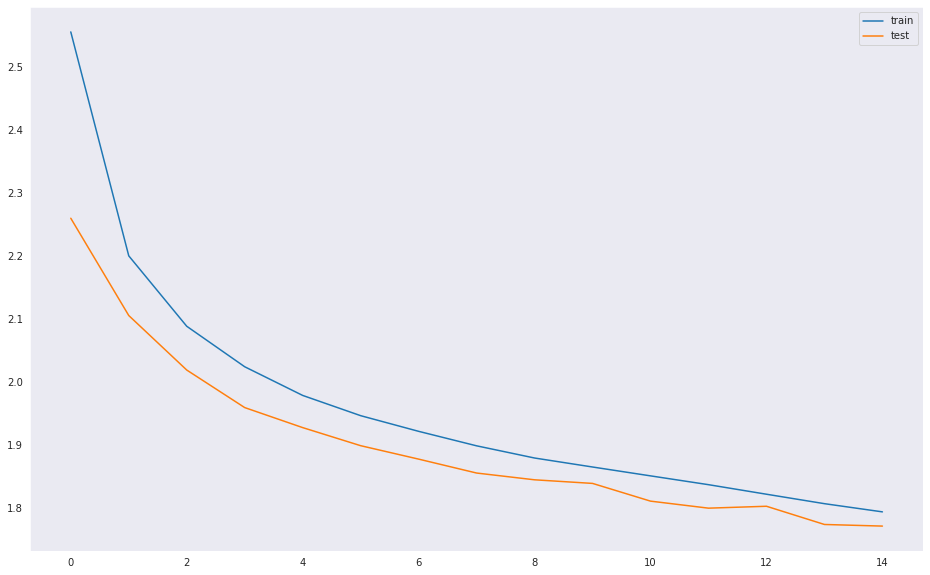

In [109]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [110]:
model.save('fp_m1_15.h5')  ## 15 epoch test

## Model 1 - 50 epochs

In [117]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=256,
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Train on 434714 samples, validate on 108501 samples
Epoch 1/50
434714/434714 [==============================] - 1324s 3ms/sample - loss: 2.5550 - val_loss: 2.2912
Epoch 2/50
434714/434714 [==============================] - 1310s 3ms/sample - loss: 2.2089 - val_loss: 2.1204
Epoch 3/50
434714/434714 [==============================] - 1310s 3ms/sample - loss: 2.0949 - val_loss: 2.0244
Epoch 4/50
434714/434714 [==============================] - 1309s 3ms/sample - loss: 2.0332 - val_loss: 1.9794
Epoch 5/50
434714/434714 [==============================] - 1310s 3ms/sample - loss: 1.9901 - val_loss: 1.9458
Epoch 6/50
434714/434714 [==============================] - 1311s 3ms/sample - loss: 1.9602 - val_loss: 1.9122
Epoch 7/50
434714/434714 [==============================] - 1308s 3ms/sample - loss: 1.9401 - val_loss: 1.8898
Epoch 8/50
434714/434714 [==============================] - 1308s 3ms/sample - loss: 1.9200 - val_loss: 1.8802
Epoch 9/50
434714/434714 [==============================] - 

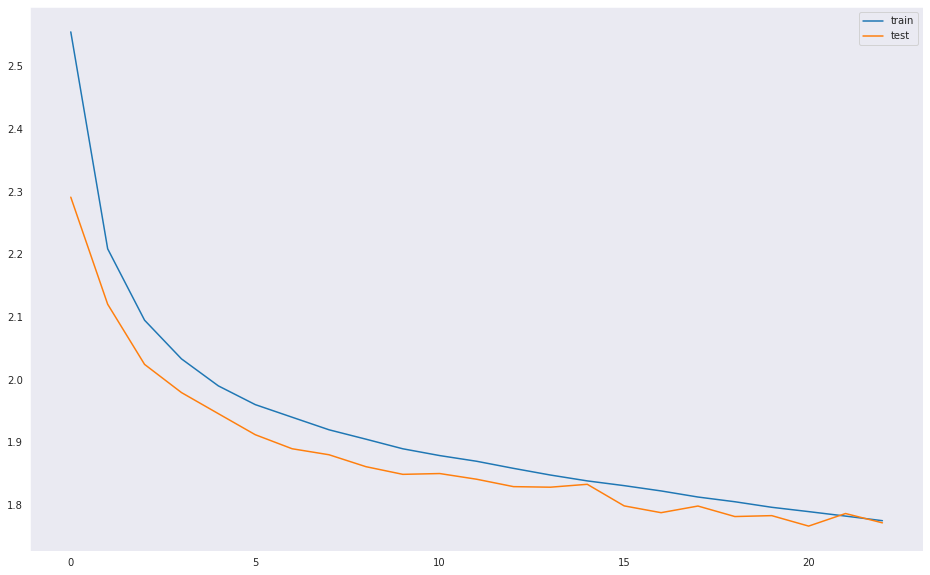

In [118]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [119]:
model.save('fp_m1_50.h5') ## 50 epoch test

## Model 2 - Roughly best at 15 epochs

In [90]:
K.clear_session()
    
latent_dim = 400
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.6)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.6)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.6)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
print(state_h, state_c)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Tensor("lstm_2/Identity_1:0", shape=(None, 400), dtype=float32) Tensor("lstm_2/Identity_2:0", shape=(None, 400), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 140, 200)     11134000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 140, 400), ( 961600      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0           

In [91]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [92]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=3)

In [93]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=15,
                  callbacks=[es],
                  batch_size=256,
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Train on 434714 samples, validate on 108501 samples
Epoch 1/15
434714/434714 [==============================] - 1845s 4ms/sample - loss: 2.4723 - acc: 0.6285 - val_loss: 2.1876 - val_acc: 0.6531
Epoch 2/15
434714/434714 [==============================] - 1831s 4ms/sample - loss: 2.1192 - acc: 0.6593 - val_loss: 2.0219 - val_acc: 0.6683
Epoch 3/15
434714/434714 [==============================] - 1826s 4ms/sample - loss: 2.0070 - acc: 0.6696 - val_loss: 1.9414 - val_acc: 0.6769
Epoch 4/15
434714/434714 [==============================] - 1826s 4ms/sample - loss: 1.9424 - acc: 0.6762 - val_loss: 1.8898 - val_acc: 0.6821
Epoch 5/15
434714/434714 [==============================] - 1825s 4ms/sample - loss: 1.8977 - acc: 0.6807 - val_loss: 1.8571 - val_acc: 0.6857
Epoch 6/15
434714/434714 [==============================] - 1825s 4ms/sample - loss: 1.8626 - acc: 0.6843 - val_loss: 1.8255 - val_acc: 0.6899
Epoch 7/15
434714/434714 [==============================] - 1825s 4ms/sample - loss: 1.836

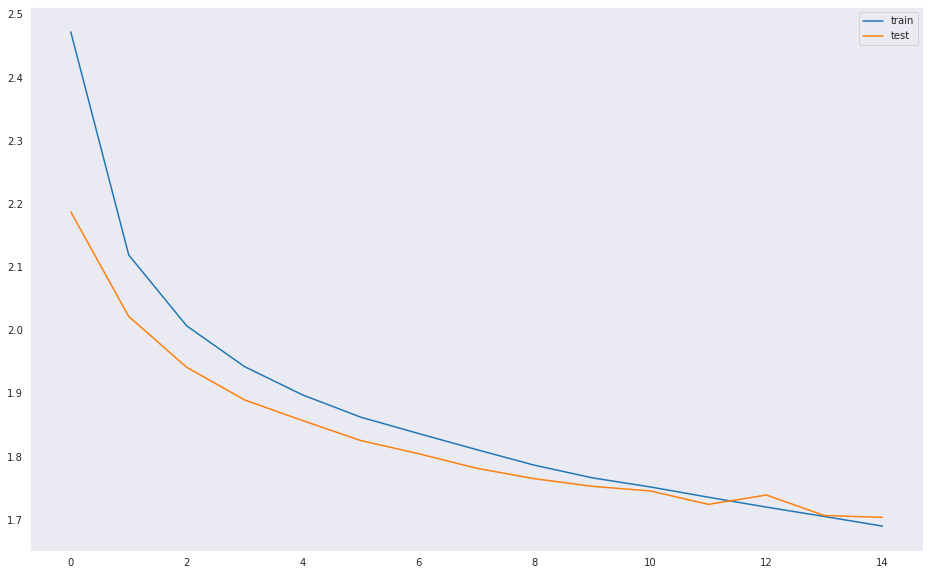

In [94]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [75]:
# model.save('fp_m2.h5')  ## 10 epoch test

In [95]:
model.save('fp_m2_15.h5')  ## 15 epoch - best case

# Model 2 - 50 epochs

In [84]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=256,
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Train on 434714 samples, validate on 108501 samples
Epoch 1/50
434714/434714 [==============================] - 1839s 4ms/sample - loss: 2.4748 - acc: 0.6284 - val_loss: 2.1828 - val_acc: 0.6533
Epoch 2/50
434714/434714 [==============================] - 1827s 4ms/sample - loss: 2.1199 - acc: 0.6594 - val_loss: 2.0269 - val_acc: 0.6680
Epoch 3/50
434714/434714 [==============================] - 1828s 4ms/sample - loss: 2.0080 - acc: 0.6699 - val_loss: 1.9452 - val_acc: 0.6758
Epoch 4/50
434714/434714 [==============================] - 1825s 4ms/sample - loss: 1.9414 - acc: 0.6764 - val_loss: 1.8888 - val_acc: 0.6827
Epoch 5/50
434714/434714 [==============================] - 1824s 4ms/sample - loss: 1.8968 - acc: 0.6812 - val_loss: 1.8587 - val_acc: 0.6861
Epoch 6/50
434714/434714 [==============================] - 1823s 4ms/sample - loss: 1.8654 - acc: 0.6848 - val_loss: 1.8377 - val_acc: 0.6877
Epoch 7/50
434714/434714 [==============================] - 1825s 4ms/sample - loss: 1.837

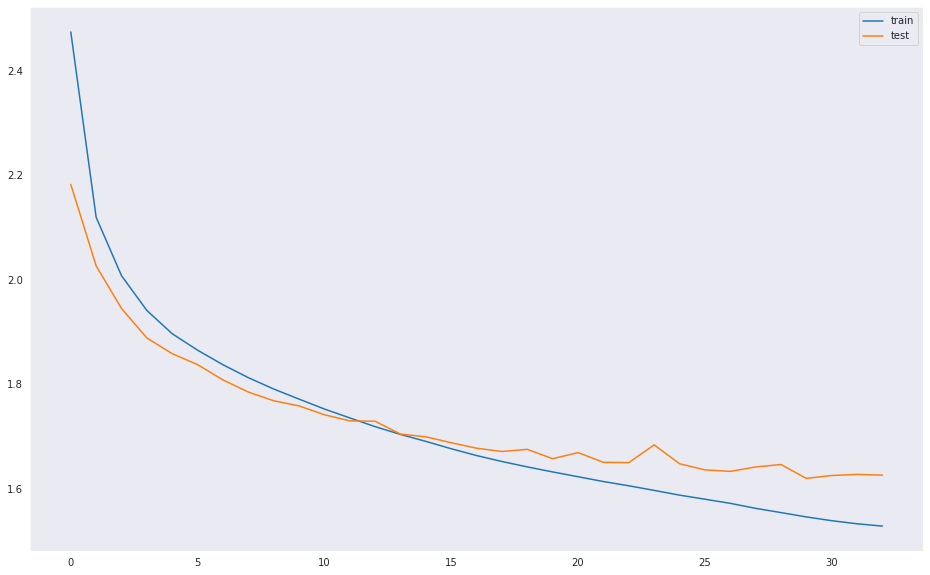

In [85]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [86]:
# model.save('fp_m2_50.h5')

### Model 4

In [58]:
K.clear_session()
    
latent_dim = 400
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.8)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.8)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.5,recurrent_dropout=0.8)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.5,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 140, 200)     11134000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 140, 400), ( 961600      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [59]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [60]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=2)

In [61]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=10,
                  callbacks=[es],
                  batch_size=256,
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Train on 434714 samples, validate on 108501 samples
Epoch 1/10
434714/434714 [==============================] - 1851s 4ms/sample - loss: 2.5212 - acc: 0.6253 - val_loss: 2.2480 - val_acc: 0.6488
Epoch 2/10
434714/434714 [==============================] - 1835s 4ms/sample - loss: 2.1826 - acc: 0.6543 - val_loss: 2.0808 - val_acc: 0.6634
Epoch 3/10
434714/434714 [==============================] - 1838s 4ms/sample - loss: 2.0704 - acc: 0.6644 - val_loss: 2.0038 - val_acc: 0.6706
Epoch 4/10
434714/434714 [==============================] - 1836s 4ms/sample - loss: 2.0017 - acc: 0.6706 - val_loss: 1.9448 - val_acc: 0.6774
Epoch 5/10
434714/434714 [==============================] - 1841s 4ms/sample - loss: 1.9567 - acc: 0.6749 - val_loss: 1.9088 - val_acc: 0.6805
Epoch 6/10
434714/434714 [==============================] - 1845s 4ms/sample - loss: 1.9249 - acc: 0.6780 - val_loss: 1.8824 - val_acc: 0.6835
Epoch 7/10
434714/434714 [==============================] - 1834s 4ms/sample - loss: 1.901

In [62]:
# model.save('fp_m4.h5')  ## 10 epoch test

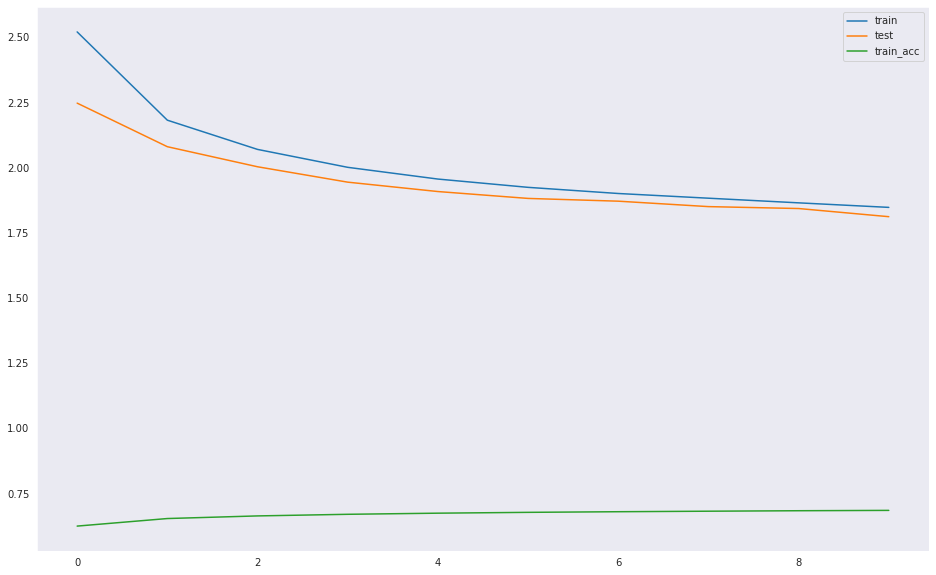

In [63]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.plot(history.history['acc'], label='train_acc')
plt.legend()
plt.show()

### Load model for testing

In [55]:
model.load_weights('fp_m4.h5')

### LSTM - Testing the model outputs

In [42]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [120]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [52]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [45]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [121]:
for i in range(0,100):
    print(i)
    print("Review:",seq2text(x_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(x_train[i].reshape(1,max_text_len)))
    print("\n")

0
Review: okay expecting crunchy type dried strawberries maybe missed something reading description also sweet son liked gave aware berries coated sugar 
Original summary: sugar high 
Predicted summary:  not what expected


1
Review: yeast extract listed ingredient sounds harmless right specifically chips contain autolyzed yeast extract chemical level monosodium glutamate derived different source toxic properties kettle still advertises products containing msg acknowledge chips safe people msg sensitivities 
Original summary: the organic label is misleading 
Predicted summary:  yeast extract label


2
Review: loved flowers however error order unable reach live person correct even though wrote email left several voice mails hour order placed still waiting refund order placed error soon battle guess used company past like product able contact anyone change order unsatisfying get promised refund use vendor 
Original summary: poor customer service 
Predicted summary:  customer service


3


Predicted summary:  great tasting chocolate


29
Review: know dog treat might mistaken piece plastic one kids many toys solid therefore keeps dog busy awhile great loves best part though scent got lovely scent warm spice smell bad crumble ideal popping pocket way dog 
Original summary: bella says yum 
Predicted summary:  my dog loves it


30
Review: beans hard impossible find usa alfa brand bean directly greece fantastic product 
Original summary: greek giant beans 
Predicted summary:  beans


31
Review: good flavor stronger expected first gulp much better newman also good warm kahlua clod night 
Original summary: very bold 
Predicted summary:  nice flavor


32
Review: opened carton found packets consisting clear packet containing described pasta similarity orzo paper packet labeled type seasoning silver foil packet held cheese another paper packet marked broccoli misnomer contents clearly appeared sawdust green shingle chicken much truth advertising actually broccoli either sawdust ap

Predicted summary:  weak coffee


54
Review: father law recommended get flax seed mill part healthier nutritious diet ordered flax seed mill noticed muffin recipe back wanted try especially wonderful reviews one problem gotten oat bran ordered tried muffin recipe whoa absolutely fantastic tried hot cereal adding tbsp flax seed mill dash salt chopped walnuts frozen blueberries touch maple syrup stuff tasty bowl breakfast maybe bowl lunch light filling without making full rest assured knowing getting fiber need day keeps regular cholesterol check happy gal 
Original summary: cannot be without this 
Predicted summary:  great for baking


55
Review: nuts great little small tasty arrived days ordered soooo much cheaper market 
Original summary: nuts 
Predicted summary:  nuts


56
Review: jerky recommended nutritionist unlike jerky contains sugar harmful additives tastes great 
Original summary: healthy snack 
Predicted summary:  great jerky


57
Review: breast cancer survivor aware organic 

Predicted summary:  great party favors


80
Review: popchip calorie bags great snack help control portions trust full sized bag taste great decent amount bags enough satisfy bland tasting like baked chips regularly order bbq flavor tried many popchip flavors personal favorites know make taste great little calories thanks popchips 
Original summary: yummy snack 
Predicted summary:  popchips are great


81
Review: think candies great nice lemony would give stars sugar coating taste nice get past candy otoh keeps sticking together plus received another order purchase hand stick extra gifts recommend tried flavors really love lemon 
Original summary: love these 
Predicted summary:  great candy


82
Review: product nice happy found way purchase able make couple healthy sized burgers box instead recommended glad find animal products ingredients price seems reasonable purchased boxes time 
Original summary: good happy lunch 
Predicted summary:  great product


83
Review: repeat customer succe

### LSTM - Generate text for ROUGE evaluation

In [66]:
def writeText(text, title, dataDir):
    with open(os.path.join(os.getcwd() + dataDir, (title + ".txt")), 'w', encoding='utf-8') as story:
        story.write(text)

In [122]:
for i in range(0,100):
#     writeText(seq2summary(y_train[i]), "REFERENCE_" + str(i), "/rogue_data/model2/provided_summaries/")
    writeText(decode_sequence(x_train[i].reshape(1,max_text_len)),\
             "GENERATED_" + str(i), "/rogue_data/model1_50/model_summaries/")

# Bi-Directional

## Model 3

In [99]:
K.clear_session()
    
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.6)
encoder_output1 = Bidirectional(encoder_lstm1)(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.6)
encoder_output2 = Bidirectional(encoder_lstm2)(encoder_output1)

#encoder lstm 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.5,recurrent_dropout=0.6)
encoder_outputs = Bidirectional(encoder_lstm3)(encoder_output2)
lstm, forward_h, forward_c, backward_h, backward_c = encoder_outputs

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])


# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs= Bidirectional(decoder_lstm)(dec_emb)#,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs[0], decoder_outputs[0]])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs[0], attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 140, 100)     5567000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 140, 600), ( 962400      embedding[0][0]                  
______________________________________________________________________________________________

In [108]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [109]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=2)

In [111]:
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=10,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Train on 434714 samples, validate on 108501 samples
Epoch 1/10
434714/434714 [==============================] - 4493s 10ms/sample - loss: 1.1986 - acc: 0.8086 - val_loss: 0.6536 - val_acc: 0.9015
Epoch 2/10
434714/434714 [==============================] - 4497s 10ms/sample - loss: 0.5577 - acc: 0.9199 - val_loss: 0.4079 - val_acc: 0.9460
Epoch 3/10
434714/434714 [==============================] - 4500s 10ms/sample - loss: 0.3926 - acc: 0.9478 - val_loss: 0.3014 - val_acc: 0.9613
Epoch 4/10
434714/434714 [==============================] - 4493s 10ms/sample - loss: 0.3006 - acc: 0.9606 - val_loss: 0.2363 - val_acc: 0.9693
Epoch 5/10
434714/434714 [==============================] - 4488s 10ms/sample - loss: 0.2460 - acc: 0.9675 - val_loss: 0.1905 - val_acc: 0.9748
Epoch 6/10
434714/434714 [==============================] - 4489s 10ms/sample - loss: 0.1992 - acc: 0.9732 - val_loss: 0.1512 - val_acc: 0.9798
Epoch 7/10
434714/434714 [==============================] - 4487s 10ms/sample - loss

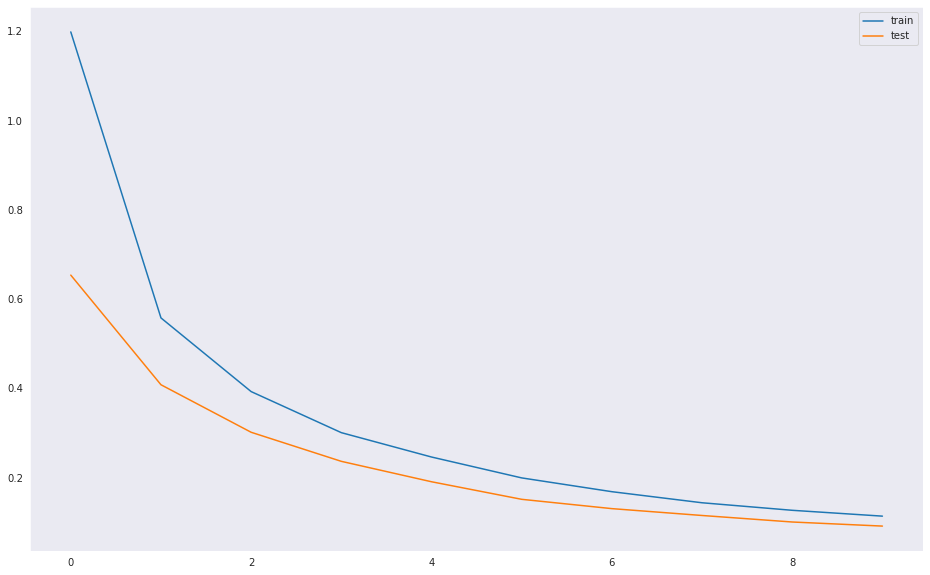

In [112]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [113]:
# model.save('fp_m3.h5')  ## 10 epoch test

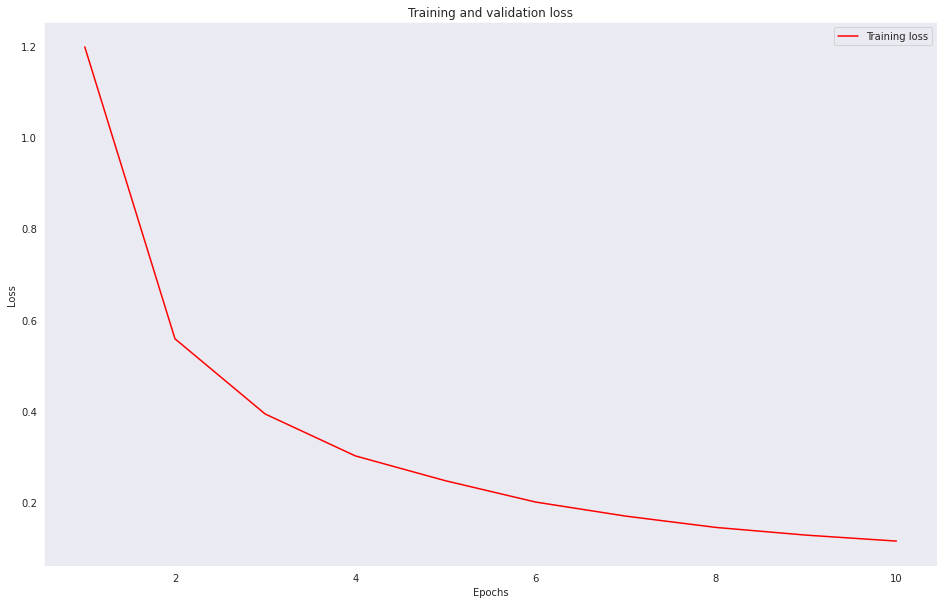

In [114]:
plotloss(history.history)

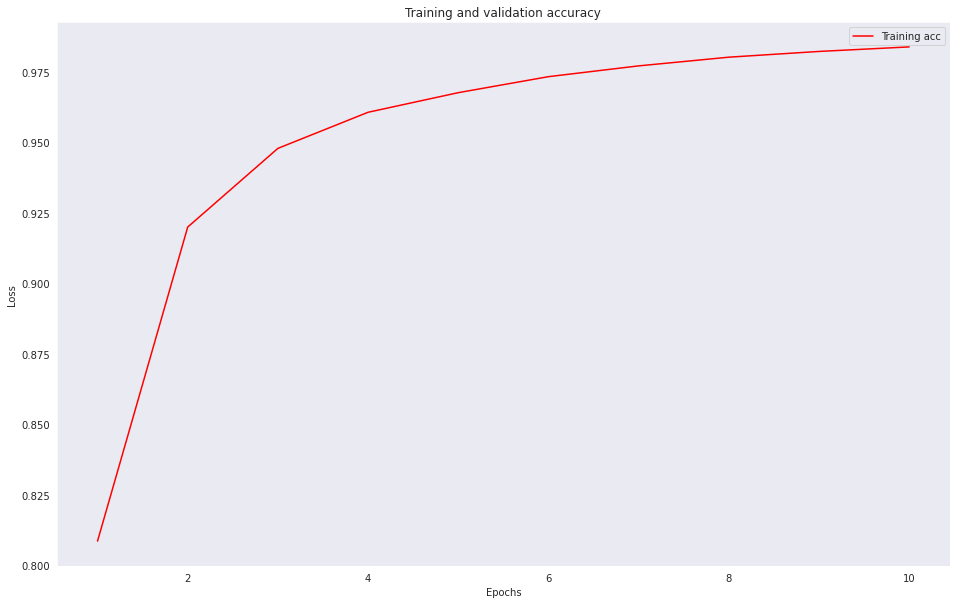

In [115]:
plotacc(history)

In [100]:
model.load_weights('fp_m3.h5')

### Bidirectional LSTM - Testing the model outputs

In [101]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs[0], state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))



# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# print(decoder_state_input_h, decoder_state_input_c, decoder_hidden_state_input)
# print(decoder_outputs[1])
# print(Bidirectional(decoder_lstm))
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decode_lstm = Bidirectional(decoder_lstm)(dec_emb2)#, \
                                                    #initial_state=[decoder_state_input_h, decoder_state_input_c])
decoder_outputs2, forward_h, forward_c, backward_h, backward_c = decode_lstm

state_h2 = Concatenate()([forward_h, backward_h])
state_c2 = Concatenate()([forward_c, backward_c])



#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [102]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [103]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [104]:
for i in range(0,100):
    print("Review:",seq2text(x_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(x_train[i].reshape(1,max_text_len)))
    print("\n")

Review: okay expecting crunchy type dried strawberries maybe missed something reading description also sweet son liked gave aware berries coated sugar 
Original summary: sugar high 
Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: yeast extract listed ingredient sounds harmless right specifically chips contain autolyzed yeast extract chemical level monosodium glutamate derived different source toxic properties kettle still advertises products containing msg acknowledge chips safe people msg sensitivities 
Original summary: the organic label is misleading 
Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: loved flowers however error order unable reach live person correct even though wrote email left several voice mails hour order placed still waiting refund order placed error soon battle guess used company past like product able contact anyone change order unsatisfy

Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: best healthy shake ever everyone family loves creamy sweet chocolaty perfect vanilla flavor creamy still tasty bit expensive worth every penny tried shakes like 
Original summary: best diet shake ever 
Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: disappointed tea taste better liptons yellow label tea expected stash loose tea since good expereience tea bags 
Original summary: stash darjeeling tea 
Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: horrified find product made china realizing give month old baby liked watch closely pieces easily break dissolve quickly enough choked luckily able cough piece cracker 
Original summary: made in china choking hazard 
Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly hon

Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: picture shows old package coffee could find anywhere reason made order dissapointed receive diffent jars turned product 
Original summary: new package the same taste 
Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: learned product friends loved later visited winery college station texas used wine tasting also sold aerator tower holds aerator researched product although different ones claim serve purpose venturi seems best job probably winery prefers make wines taste even better people purchasing frequently winery impressed improvement wine flavor trying without tasting getting whole set price tax free amazon made love even 
Original summary: amazing product 
Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: bars perfect grab go morning afternoon addition 

Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: quote keeps getting funnier every single time see put good use say watch movie say tim burton cannot stop good movies least top best comedies time twisted funny swear watch film get one laugh probably give chance course beetlejuice one famous movie history way go tim 
Original summary: it is showtime 
Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: doctor told lose weight going insulin months desperately looking healthy food choices worried much taste calories per calories fat mg sodium protein whopping fiber cans fit bill yes great flavor mixed cooked quinoa brown rice added tuna sardines good 
Original summary: low salt and healthy 
Predicted summary:  honestly honestly honestly honestly honestly honestly honestly honestly honestly


Review: bones great compressed rawhide lasts much longer rawhides making great p

KeyboardInterrupt: 